Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


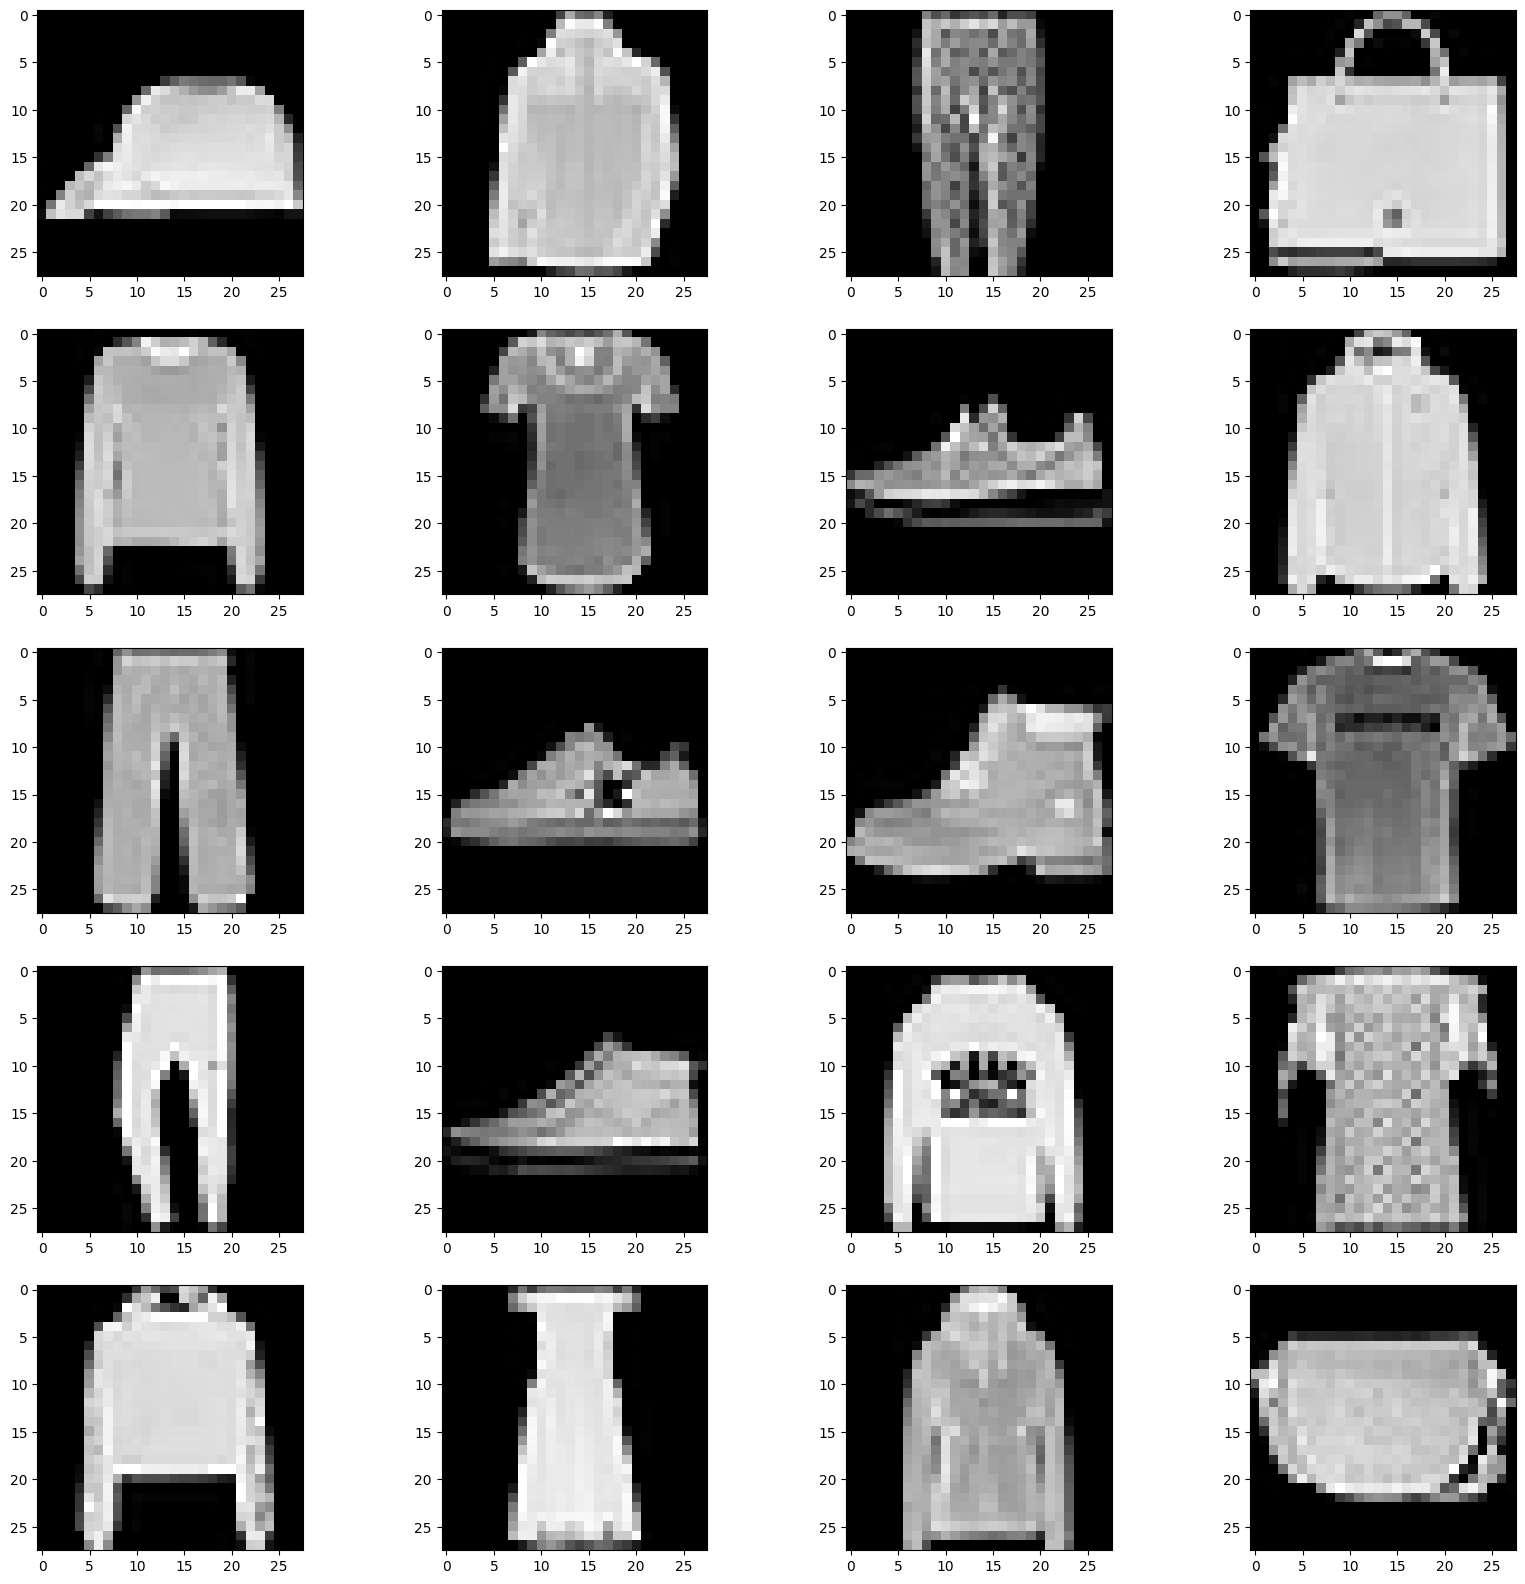

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from google.colab import drive
drive.mount('/content/drive')
classifier_train = pd.read_csv("/content/drive/My Drive/WOC/classification_train.csv")
classifier_train.head()
plt.figure(figsize=(20,20))
plots = []
for i in range(20):
    ax = plt.subplot2grid((5,4), (i//4,i%4))
    image1 = classifier_train[:][i:i+1]#.to_numpy()
    #image1.reshape((28,28))
    image1 = image1.iloc[:,2:].to_numpy().reshape((28,28))
    ax.imshow(image1,cmap='gray')
ratio_train = 0.80
ratio_cv = 0 #since there is no hyperparameter tuning involved,nor trying different models,only train and test data set is sufficient
classifier_train = classifier_train.sample(frac=1) #shuffle
total_rows = classifier_train.shape[0]
total_train = int(total_rows*ratio_train)
total_cv = int(total_rows*ratio_cv)
X_train = classifier_train.iloc[:total_train,2:].to_numpy()
X_cv = classifier_train.iloc[total_train:total_train+total_cv,2:].to_numpy()
X_test = classifier_train.iloc[total_train+total_cv:,2:].to_numpy()
Y_train = classifier_train.iloc[:total_train,1:2].to_numpy().reshape((total_train,))
Y_cv = classifier_train.iloc[total_train:total_train+total_cv,1:2].to_numpy().reshape((total_cv,))
Y_test = classifier_train.iloc[total_train+total_cv:,1:2].to_numpy().reshape((total_rows-total_train-total_cv,))

In [45]:
ratio_train=0.8
ratio_cv = 0
ratio_test=0.2
total_rows = classifier_train.shape[0]
total_train = int(total_rows*ratio_train)
total_cv = int(total_rows*ratio_cv)
shuffled_df = classifier_train.sample(frac=1,random_state=12)
grped_df = shuffled_df.groupby('label')
ans = [np.split(df_label,[int(ratio_train*len(df_label)),int((ratio_train+ratio_cv)*len(df_label))])for label,df_label in grped_df]
df_train = pd.concat([x[0] for x in ans]).sample(frac=1,random_state=12)
df_cv = pd.concat([x[1] for x in ans]).sample(frac=1,random_state=12)
df_test = pd.concat([x[2] for x in ans]).sample(frac=1,random_state=12)
#df_train
X_train = df_train.iloc[:,2:].to_numpy()
X_cv = df_cv.iloc[:,2:].to_numpy()
X_test = df_test.iloc[:,2:].to_numpy()
Y_train = df_train.iloc[:,1:2].to_numpy().reshape((total_train,))
Y_cv = df_cv.iloc[:,1:2].to_numpy().reshape((total_cv,))
Y_test = df_test.iloc[:,1:2].to_numpy().reshape((total_rows-total_train-total_cv,))

In [34]:
class logisticregression:
    def __init__(self,typ='softmax',learning_rate=0.001,epochs=1000,base=0.5,reg_lambda=0):
        self.lr = learning_rate
        self.epochs = epochs
        self.theta = None
        self.base = base
        self.reg_lambda = reg_lambda
        self.typ = typ
    def save_weights(self):
        with open("model_weights_"+self.typ+"_"+time.strftime("%Y%m%d-%H%M%S")+".txt","w") as f:
          f.write("theta:" + str(self.theta.tolist()) + "\n")
    def load_weights(self,filename):
        with open(filename, "r") as f:
            lines = f.readlines()
            self.theta = np.array(lines[0].split(":")[1].strip().strip('[').strip(']').split(','))
            if self.theta.shape[0] > 1 and self.theta.shape[1] > 1:
                self.theta[-1, -1] = float(self.theta[-1, -1][:-1])
            elif self.theta.shape[0] > 1:
                self.theta[-1] = float(self.theta[-1][:-1])
            else:
                self.theta = float(self.theta[0][:-1])
    def sigmoid(self,X):
        return 1/(1+np.exp(-X))
    def softmax(self,Z):
        return np.exp(Z)/np.sum(np.exp(Z),axis=1,keepdims=True)
    def onevsall(self,Z):
        return self.sigmoid(Z)
    def fit(self,X,Y,n_classes):# x - (m,n) y - (m,k)
        X = (X - np.mean(X,axis=0))/(np.std(X,axis=0))
        n_samples,n_features = X.shape
        Y_dup = Y
        Y = np.eye(n_classes)[Y]
        #self.theta = np.random.randn(n_features,n_classes)*np.sqrt(1/(n_features+n_classes))
        self.theta = np.zeros((n_features,n_classes))*1.0
        costs = []
        accs = []
        for epoch in range(self.epochs):
          if self.typ=='softmax':
            Yh = self.softmax(X.dot(self.theta))
          else:
            Yh = self.onevsall(X.dot(self.theta))
          J = (-1/n_samples)*(np.sum(Y*np.log(Yh))) + (1/(2*n_samples))*(self.reg_lambda)*np.sum(self.theta[1:]**2)
          grads = (1/n_samples)*np.dot(X.T,(Yh-Y))+(self.reg_lambda/n_samples)*np.vstack([np.zeros((1,n_classes)),self.theta[1:]])
          self.theta -= self.lr*grads
          costs.append(J)
          
          if epoch%100==0:
            acc = self.accuracy(X,Y_dup)
            print(f"Epoch: {epoch}=> cost:- {J} accuracy:- {acc}")
        self.save_weights()
        plt.figure(figsize=(10,10))
        plt.plot(np.arange(self.epochs),costs,'r',5) 
    def accuracy(self,X,Y):
        Y_pred = self.pred(X)
        return np.mean(Y==Y_pred)
    def pred(self,X):
        X = (X - np.mean(X,axis=0))/(np.std(X,axis=0))
        if self.typ=='softmax':
          Yh = self.softmax(np.dot(X,self.theta))
        else:
          Yh = self.onevsall(np.dot(X,self.theta))
        return  np.argmax(Yh,axis=1)

In [ ]:
print(X_train.shape)

(18000, 784)


#ONE vs ALL IMPLEMENTATION

Epoch: 0=> cost:- 0.8292006328643188 accuracy:- 0.0985
Epoch: 100=> cost:- 0.3545800124194383 accuracy:- 0.5374583333333334
Epoch: 200=> cost:- 0.2788630432649751 accuracy:- 0.6325
Epoch: 300=> cost:- 0.24357051552026257 accuracy:- 0.6698333333333333
Epoch: 400=> cost:- 0.22239770195004405 accuracy:- 0.691
Epoch: 500=> cost:- 0.2080799617185381 accuracy:- 0.7050833333333333
Epoch: 600=> cost:- 0.19764720657942847 accuracy:- 0.7140416666666667
Epoch: 700=> cost:- 0.18964902895440144 accuracy:- 0.7209166666666667
Epoch: 800=> cost:- 0.18329120263686915 accuracy:- 0.7263333333333334
Epoch: 900=> cost:- 0.1780998383760163 accuracy:- 0.7315416666666666


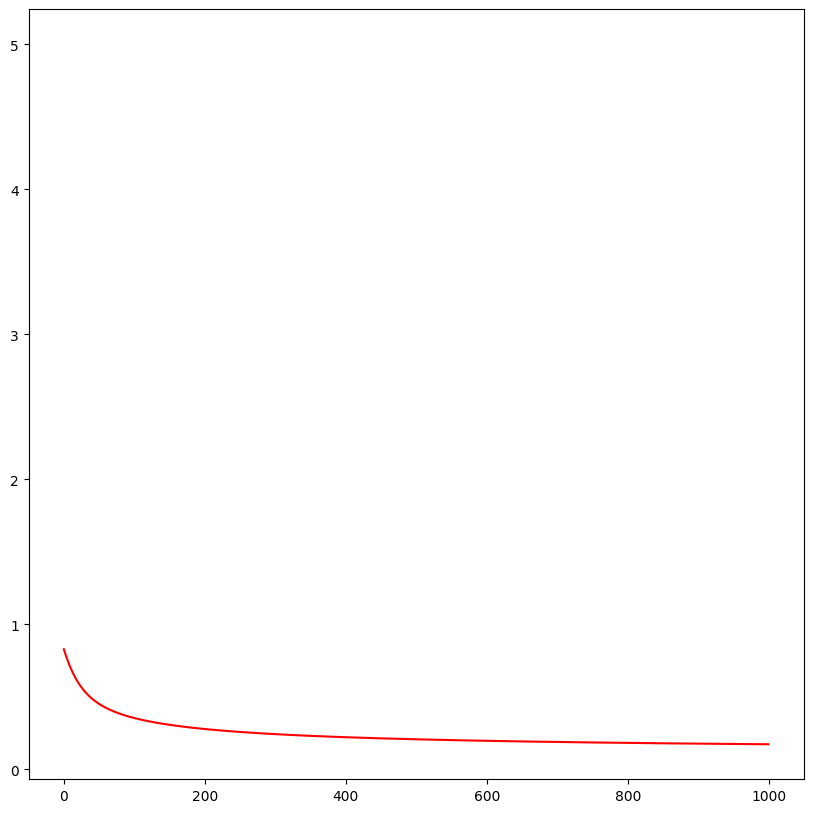

In [28]:
model = logisticregression(typ='onevsall')
model.fit(X_train,Y_train,n_classes=10)


In [29]:
model.accuracy(X_test,Y_test)

0.7361666666666666

## SOFTMAX implementation

Epoch: 0=> cost:- 2.302585092994046 accuracy:- 0.6427083333333333
Epoch: 100=> cost:- 1.2436434656912458 accuracy:- 0.6850833333333334
Epoch: 200=> cost:- 1.011495674209323 accuracy:- 0.708375
Epoch: 300=> cost:- 0.9043632479966792 accuracy:- 0.7247083333333333
Epoch: 400=> cost:- 0.8389436883920164 accuracy:- 0.7379583333333334
Epoch: 500=> cost:- 0.7934346101321161 accuracy:- 0.7484583333333333
Epoch: 600=> cost:- 0.7593184582700313 accuracy:- 0.7559166666666667
Epoch: 700=> cost:- 0.7324686277507557 accuracy:- 0.7623333333333333
Epoch: 800=> cost:- 0.7105977516688539 accuracy:- 0.7679166666666667
Epoch: 900=> cost:- 0.6923167776979665 accuracy:- 0.773
Epoch: 1000=> cost:- 0.6767257035901098 accuracy:- 0.7782916666666667
Epoch: 1100=> cost:- 0.6632125779490543 accuracy:- 0.7819583333333333
Epoch: 1200=> cost:- 0.6513452500234108 accuracy:- 0.7857083333333333
Epoch: 1300=> cost:- 0.6408088865707379 accuracy:- 0.7893333333333333
Epoch: 1400=> cost:- 0.6313679780466723 accuracy:- 0.7918

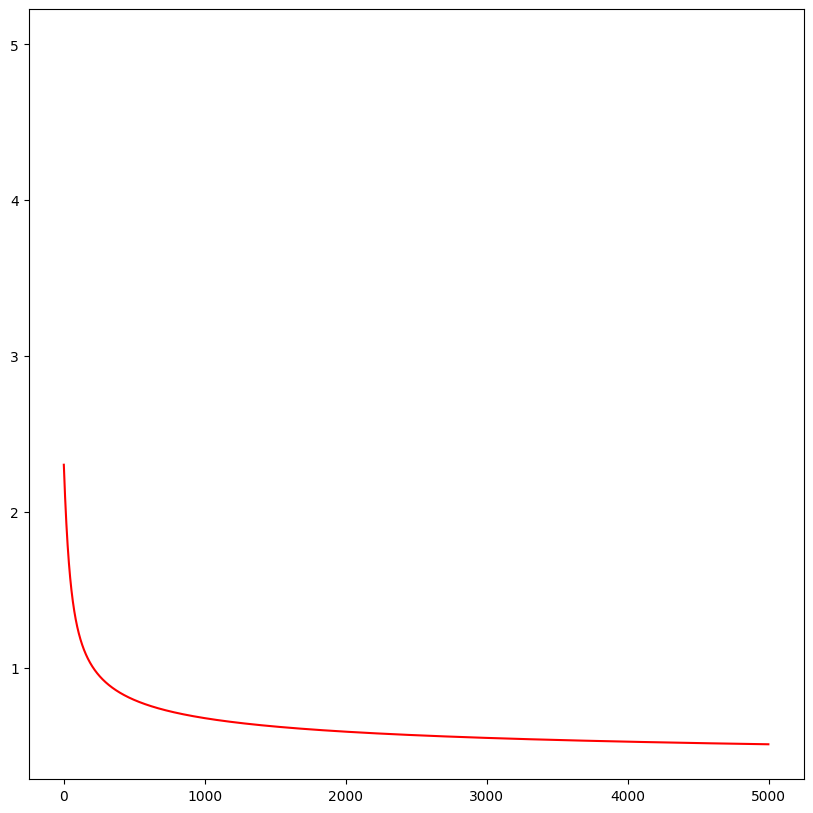

In [47]:
model1 = logisticregression(typ='softmax',epochs=5000)
model1.fit(X_train,Y_train,n_classes=10)

In [40]:
model1.accuracy(X_test,Y_test)

0.8175

In [18]:
Y_pred_cv = model1.pred(X_cv)
Y_pred_cv

array([7, 0, 3, ..., 2, 7, 3])

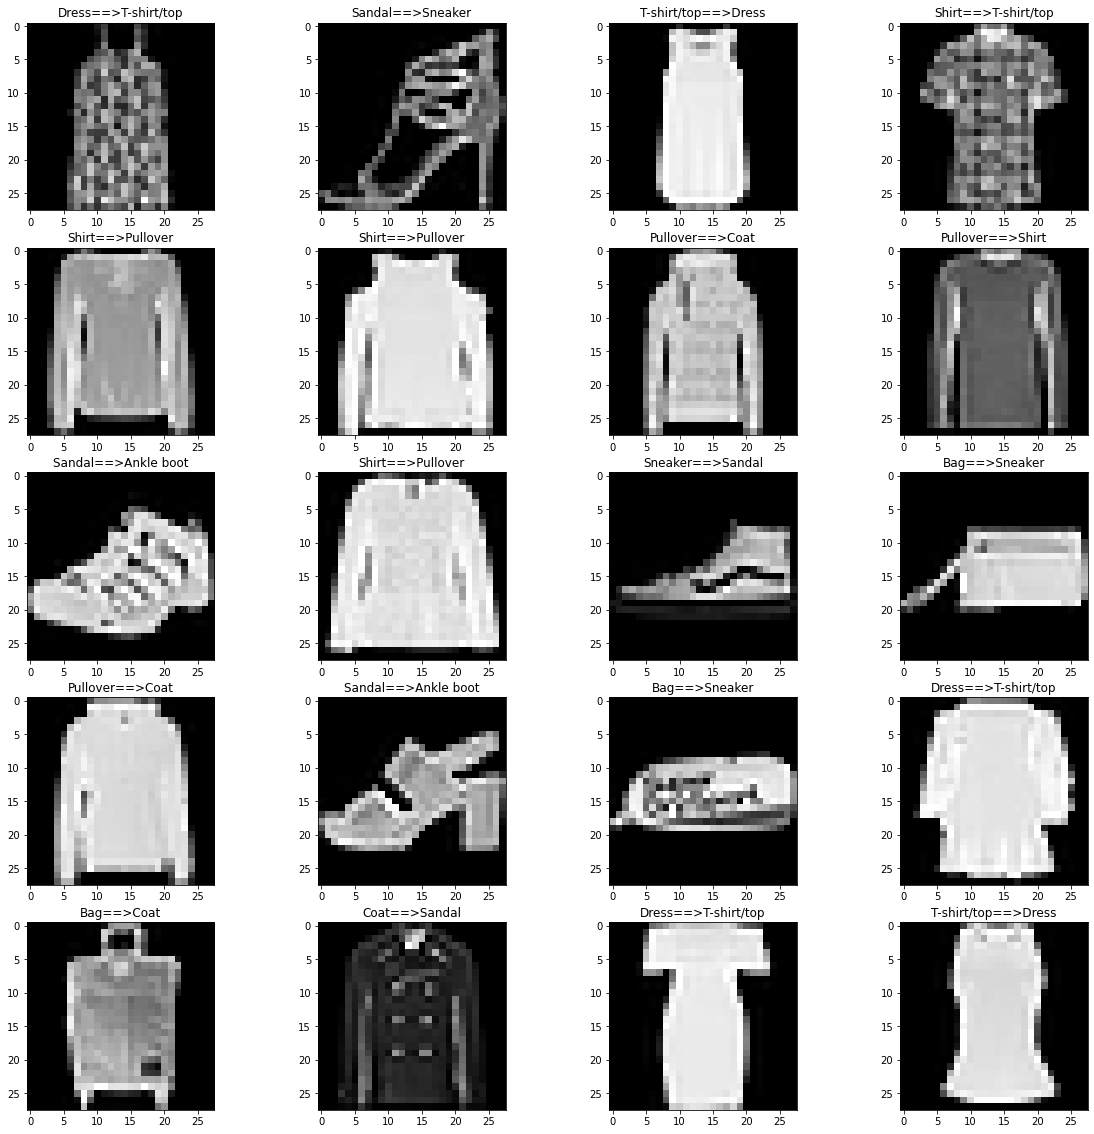

In [19]:
plt.figure(figsize=(20,20))
plots = []
j = 0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(total_cv):
  if Y_pred_cv[i] != Y_cv[i]:
      if j==20:
        break
      ax = plt.subplot2grid((5,4), (j//4,j%4))
      j+=1
      image1 = X_cv[:][i:i+1].reshape((28,28))
      ax.title.set_text(class_names[Y_cv[i]]+"==>"+class_names[Y_pred_cv[i]])
      ax.imshow(image1,cmap='gray')

In [19]:
Y_pred_test = model1.pred(X_test)

In [20]:
Y_pred_test

array([3, 2, 5, ..., 5, 2, 1])

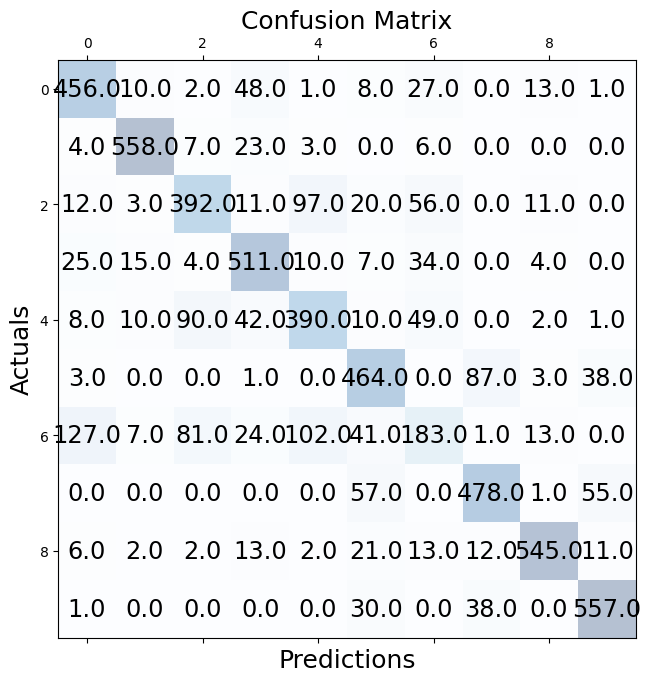

In [21]:
conf_matrix = np.zeros((10,10))
n = Y_test.shape[0]  
for i in range(n):
  conf_matrix[Y_test[i]][Y_pred_test[i]]+=1
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

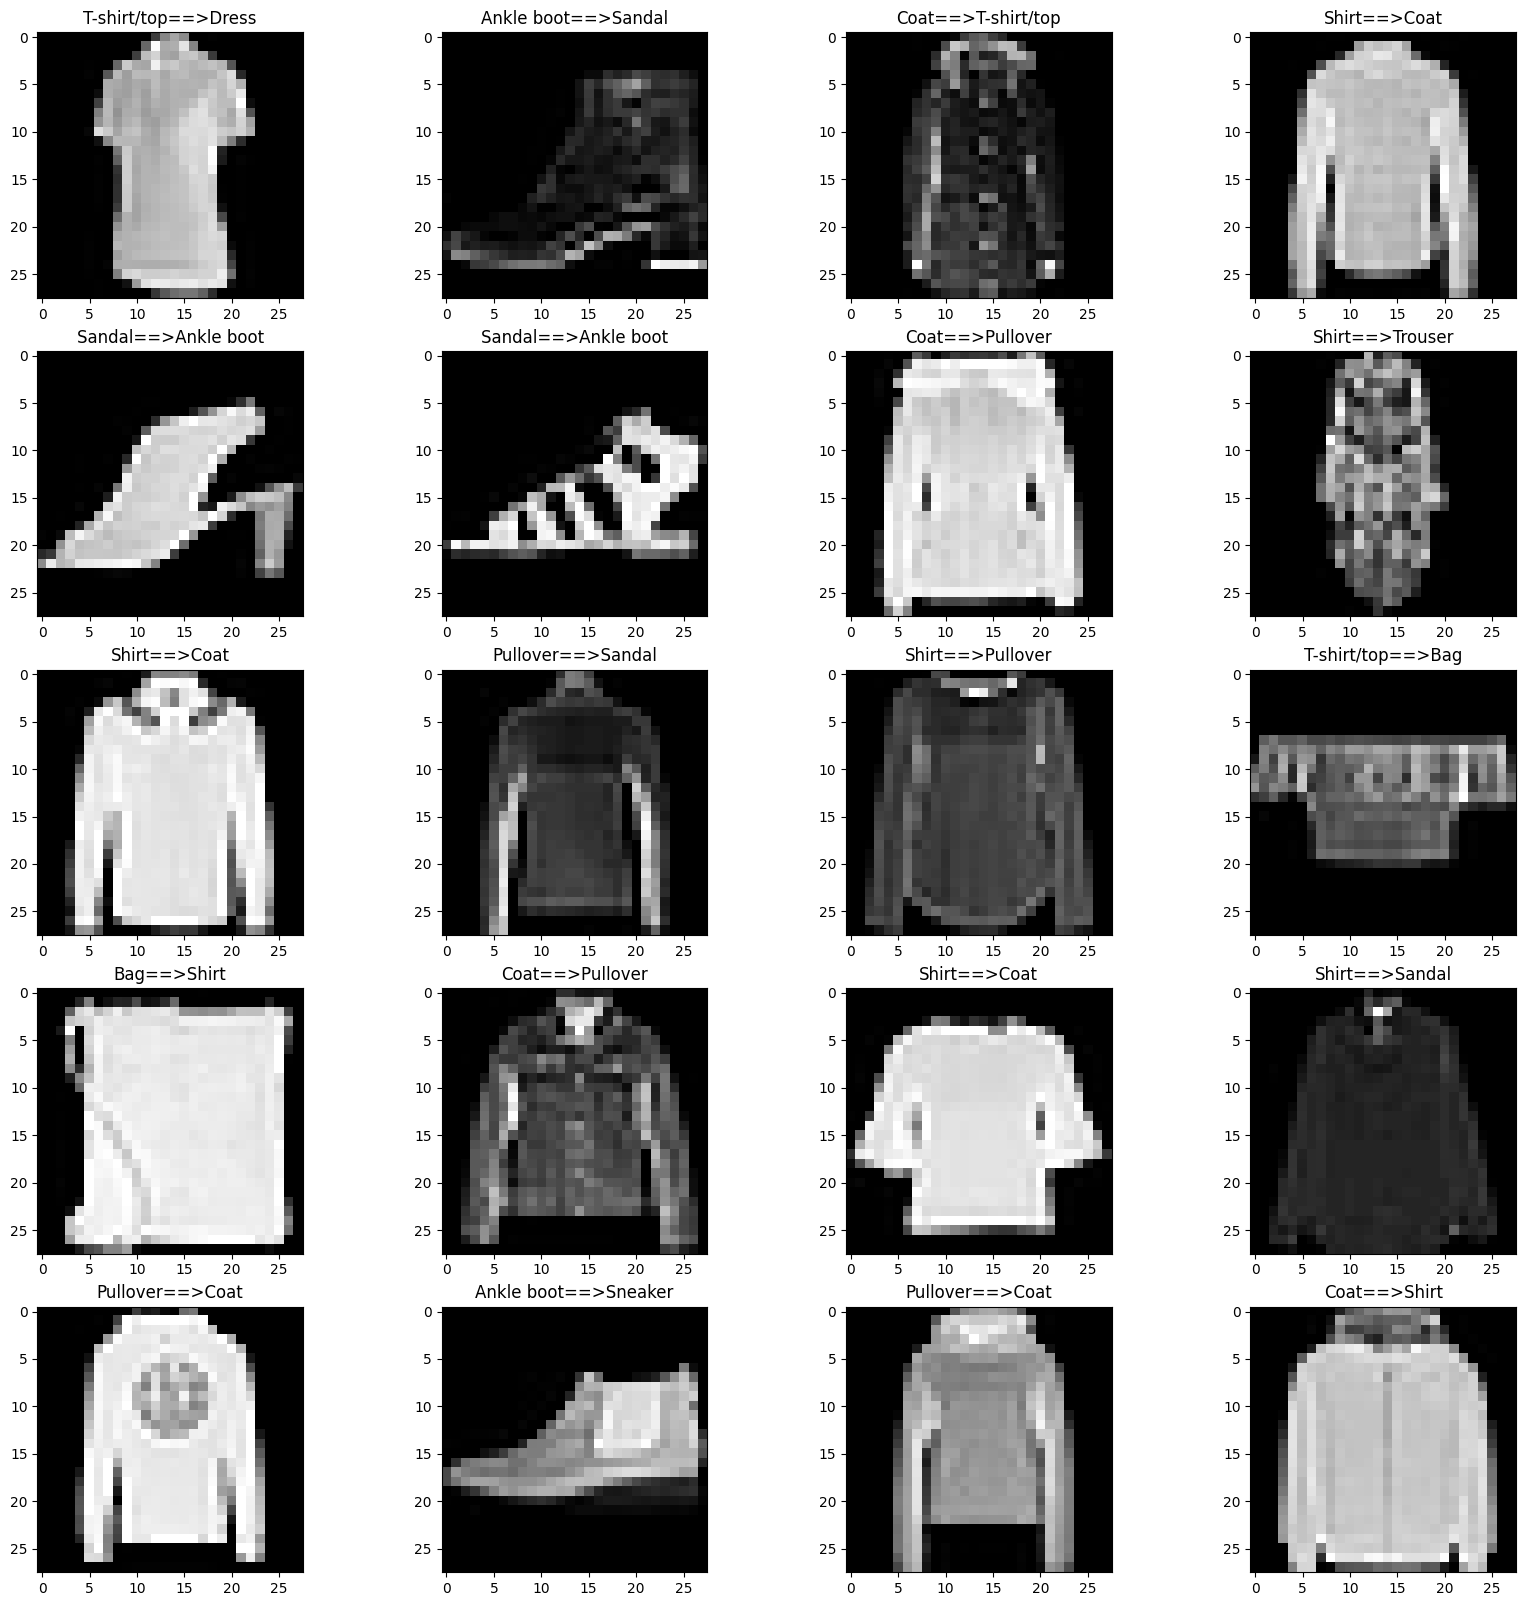

In [24]:
plt.figure(figsize=(20,20))
plots = []
j = 0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(total_rows-total_train-total_cv):
  if Y_pred_test[i] != Y_test[i]:
      if j==20:
        break
      ax = plt.subplot2grid((5,4), (j//4,j%4))
      j+=1
      image1 = X_test[:][i:i+1].reshape((28,28))
      ax.title.set_text(class_names[Y_test[i]]+"==>"+class_names[Y_pred_test[i]])
      ax.imshow(image1,cmap='gray')